# Guru strategies

In this analysis seven guru strategies will be tested on companies from Warsaw Stock Exchange. These strategies were created basing on NYSE in various years. The benchmark of these strategies would be Benjamin Graham's *zero effort strategy* assuming investing in just market index (in this case Warsaw Stock Exchange Index).

The analyzed dataset was created with data from biznesradar.pl website and contains information from WSE companies' financial reports and some economic indices like USD/PLN exchange rate, GDP of Poland, unemployment rate etc., as well as all necessary indices for checking guru strategies. Each strategy would be tested only for observations, which provide all indices required by given strategy.

The purpose of this analysis is to check if given strategy properly classifies companies, which prices increased the most in the following year (including capital gains tax (19% in Poland) and inflation rate).

These principles are the fundamentals of this analysis:
1. First of all, do not lose - a preferred strategy is not loss-making, even if it brings only small profits.
2. Assume the profit threshold you want to achieve within one year by buying shares of a given company.
3. If the company has achieved the assumed profit treshold within one year of purchase, sell it.
4. If the company has not achieved the assumed profit after a year, sell it.

The **best_price_dynamics_y** feature represents the best scenario dynamics of price in the following year, i.e.
- if in Q1 2020 company's price was 100, and in the next four quarters (i.e. Q2 2020, Q3 2020, Q4 2020 and Q1 2021) it was 101, 105, 103 and 104 respectively, the **best_price_dynamics_y** would be 0.05 (i.e. (105 - 100) / 100);
- if in Q1 2020 company's price was 100, and in the next four quarters (i.e. Q2 2020, Q3 2020, Q4 2020 and Q1 2021) it was 95, 96, 97 and 90 respectively, the **best_price_dynamics_y** would be -0.03 (i.e. (97 - 100) / 100).

The **price_dynamics_y** feature represents dynamics of price after the following year, e.g. dynamics between Q1 2020 and Q1 2021.

The **adj_best_price_dynamics_y** and **adj_price_dynamics_y** features represent **best_price_dynamics_y** and **price_dynamics_y** adjusted by capital gains tax and inflation rate. It does not include transaction fees, as they may vary depending on broker, transaction value etc.

Similar rules apply to **best_wig_dynamics_y** and **wig_dynamics_y**, except that these features represent dynamics of WIG (Warsaw Stock Exchange Index), which serves as a benchmark for each strategy.

The **final_price_dynamics** takes value of given treshold if **adj_best_price_dynamics_y** exceeds it and **price_dynamics_y** otherwise. Similarly works **final_wig_dynamics**. This logic is consistent with points 3. and 4. - we sell company if it reaches given treshold or at the end of year regardless of its price.

Finally, **interesting_company** is a variable which takes *Yes* if given company provides profit above treshold and *No* otherwise.

In [264]:
# Packages loading
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [265]:
# Dataset loading (the newest full dataset)
dataset = pd.read_csv(
    max(
        glob.glob(os.getcwd().replace('analysis', '') + 'data\\full_datasets\\*.csv'),
        key = os.path.getctime
    ),
    index_col=False
)

In [266]:
# Custom functions and other option changes

def custom_heatmap(cross_tab, ax):
    """Function for simpler creating heatmaps"""
    return sns.heatmap(
        data=cross_tab,
        cmap='Blues',
        fmt='.0%',
        annot=True,
        cbar=False,
        ax=ax
    )

pd.options.display.float_format = '{:.2f}'.format

In [267]:
# There is a wrong price reported by company FMG in Q4 2018. The company reported price at 0.15 - however, in neighbouring quarters it was 30.93 and 28. 
# Checking this information on another stock exchange website (stooq.pl) confirms that this is an incorrect value - this company was listed on the stock 
# exchange only once in Q4 2018, but with a price of 29, which is a better approximation of the real price.
idx = dataset.loc[
    np.where(
        (dataset.company_code == 'FMG')
        & (dataset.quarter == '2018/Q4')
    )  
].index[0]

dataset.loc[idx, 'price'] = 29
dataset.loc[idx, 'best_price_dynamics_y'] = (28 - 29) / 29
dataset.loc[idx, 'price_dynamics_y'] = (9 - 29) / 29

In [268]:
# Adding adjusted dynamics
dataset['adj_best_price_dynamics_y'] =  81 * dataset.best_price_dynamics_y / dataset.inflation_yy_m
dataset['adj_price_dynamics_y'] =  81 * dataset.price_dynamics_y / dataset.inflation_yy_m
dataset['adj_best_wig_dynamics_y'] =  81 * dataset.best_wig_dynamics_y / dataset.inflation_yy_m
dataset['adj_wig_dynamics_y'] =  81 * dataset.wig_dynamics_y / dataset.inflation_yy_m

The very first question is: what treshold value should be set? Too low will mean that we will sell the company's shares too early, when it could still achieve a higher profit. On the other hand, if we are too greedy, we may miss the price peak. In addition, setting the bar too high may result in a very small number of interesting companies. Or, if we want to outperform the zero effort strategy, maybe we should set the treshold higher than WIG dynamics in given quarter?

Benjamin Graham recommended a minimum portfolio size from 10 (for his most defensive strategy) to 30 companies. Given that we analyze 69 quarters, our number of interesting companies over time should be more or less in interval of 690 - 2070 and number of companies in each quarter in interval 10 - 30. Moreover, the histogram of **adj_best_price_dynamics_y** indicates, that setting treshold over 1 would leave us too few observations to fill the portfolio.

The 75th percentile of **adj_best_price_dynamics_y** is 0.31, which means that 25% of observations were able to achieve profit higher than 31%. The treshold of 0.3 could be a good start: it provides reasonable number of observations and the analysis of each predefined guru strategy would indicates whether this treshold is too high or too low. Let's add **final_price_dynamics**, **final_wig_dynamics** and **interesting_investment** with treshold of 0.3 to the dataset - they would serve as temporary target features.

*There is a huge gap between the 75th percentile (0.31) and maximum value (66.32) of **adj_best_price_dynamics_y**. However, such great increase in price values did happen in 2020 - the best example is MERCATOR, which price in 2019 was in the ballpark of a few PLNs, while in 2020 it skyrocketed to about 500 PLN. Although such observations may be seen as outliers, according to point 3. we sell company at given treshold anyway, so our investments would never achieve such high profit.*

In [269]:
print('The basic statistics of price and WIG dynamics:')
dataset[['adj_best_price_dynamics_y', 'adj_price_dynamics_y', 'adj_best_wig_dynamics_y', 'adj_wig_dynamics_y']].describe()

The basic statistics of price and WIG dynamics:


,adj_best_price_dynamics_y,adj_price_dynamics_y,adj_best_wig_dynamics_y,adj_wig_dynamics_y
count,19182.00,19182.00,19182.00,19182.00
mean,0.27,0.11,0.10,0.04
std,1.14,1.11,0.13,0.18
min,-0.80,-0.80,-0.11,-0.40
25%,-0.03,-0.22,0.00,-0.08
50%,0.08,-0.01,0.06,0.02
75%,0.31,0.21,0.17,0.15
max,66.32,66.32,0.60,0.60


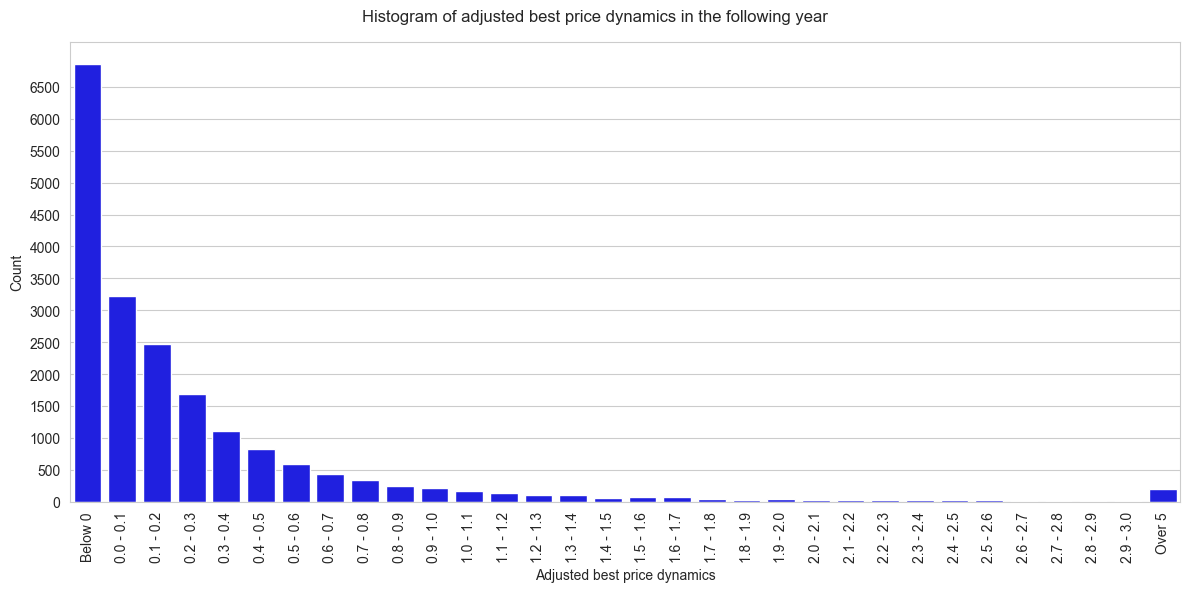

In [323]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(
    x=pd.cut(
        dataset.adj_best_price_dynamics_y,
        bins=[-.8] + list(np.arange(0, 3.1, .1)) + [67],
        labels=['Below 0'] + [f'{round(i, 1)} - {round(i + 0.1, 1)}' for i in np.arange(0, 3, .1)] + ['Over 5']
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)
plt.yticks(range(0, 7000, 500))

ax.set_xlabel('Adjusted best price dynamics')
ax.set_ylabel('Count')

plt.suptitle('Histogram of adjusted best price dynamics in the following year')

plt.tight_layout();

In [337]:
# Adding final price and WIG dynamics depending on treshold
for i in range(10, 110, 10):
    dataset[
        ''.join(['final_price_dynamics_', str(i)])
    ] = pd.Series(np.where(
        dataset.adj_best_price_dynamics_y > i / 100,
        i / 100, dataset.adj_price_dynamics_y
    ))

    dataset[
        ''.join(['final_wig_dynamics_', str(i)])
    ] = pd.Series(np.where(
        dataset.adj_best_wig_dynamics_y > i / 100,
        i / 100, dataset.adj_wig_dynamics_y
    ))
    
    dataset[
        ''.join(['final_price_dynamics_', str(i), '_over_wig'])
    ] = pd.Series(np.where(
        dataset.adj_best_price_dynamics_y > i / 100 + dataset[''.join(['final_wig_dynamics_', str(i)])],
        i / 100 + dataset[''.join(['final_wig_dynamics_', str(i)])],
        dataset.adj_price_dynamics_y
    ))

In [343]:
dataset[dataset.final_price_dynamics_100 == 1].groupby('quarter').final_price_dynamics_100.count().mean()

18.609375

In [331]:
for i in range(10, 110, 10):
    print(f'\nPercentage of investments which reported loss using treshold of {i}%:', end=' ')
    print(
        round(
            100 * len(
                dataset[dataset[''.join(['final_price_dynamics_', str(i)])] < 0][''.join(['final_price_dynamics_', str(i)])]
            ) / len(dataset), 2
        ),
        end='%'
    )
for i in range(10, 110, 10):
    print(f'\nPercentage of investments which reported loss using treshold of {i}% over WIG:', end=' ')
    print(
        round(
            100 * len(
                dataset[dataset[''.join(['final_price_dynamics_', str(i), '_over_wig'])] < 0][''.join(['final_price_dynamics_', str(i), '_over_wig'])]
            ) / len(dataset), 2
        ),
        end='%'
    )


Percentage of investments which reported loss using treshold of 10%: 42.89%
Percentage of investments which reported loss using treshold of 20%: 47.43%
Percentage of investments which reported loss using treshold of 30%: 49.17%
Percentage of investments which reported loss using treshold of 40%: 49.81%
Percentage of investments which reported loss using treshold of 50%: 50.12%
Percentage of investments which reported loss using treshold of 60%: 50.31%
Percentage of investments which reported loss using treshold of 70%: 50.41%
Percentage of investments which reported loss using treshold of 80%: 50.47%
Percentage of investments which reported loss using treshold of 90%: 50.53%
Percentage of investments which reported loss using treshold of 100%: 50.56%
Percentage of investments which reported loss using treshold of 10% over WIG: 51.63%
Percentage of investments which reported loss using treshold of 20% over WIG: 48.56%
Percentage of investments which reported loss using treshold of 30% 

Assuming the treshold at 0.3, there are 4936 interesting investments - about 1/4 of all observations. Almost half of companies would actually reported loss in the following year, with -0.8 as minimum **final_price_dynamics**. The mean **final_price_dynamics** is -0.02: if we randomly invest in a company and keep with points 3. and 4., we would actually make a loss.

In [7]:
print('The basic statistics of final price dynamics:')
print(dataset.final_price_dynamics.describe())
print('\nThe count of interesting companies:')
print(dataset.interesting_investment.value_counts())

The basic statistics of final price dynamics:
count   19182.00
mean       -0.02
std         0.27
min        -0.80
25%        -0.21
50%         0.00
75%         0.30
max         0.30
Name: final_price_dynamics, dtype: float64

The count of interesting companies:
No     14246
Yes     4936
Name: interesting_investment, dtype: int64


In [8]:
loss_count = 100 * len(dataset[dataset.final_price_dynamics < 0].final_price_dynamics) / len(dataset)
print(f'Percentage of companies which reported loss: {round(loss_count, 2)}%')

Percentage of companies which reported loss: 49.17%


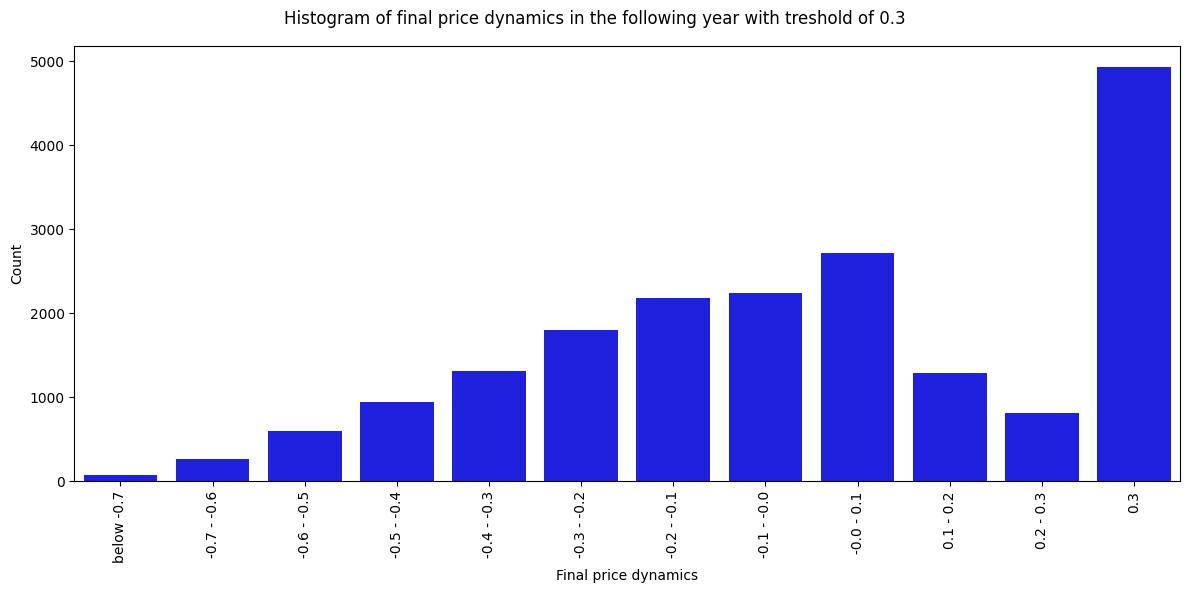

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(
    x=pd.cut(
        dataset.final_price_dynamics,
        bins=list(np.arange(-.8, .4, .1)),
        labels=['Below -0.7'] + [f'{round(i, 1)} - {round(i + 0.1, 1)}' for i in np.arange(-.7, .3, .1)] + ['0.3']
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Final price dynamics')
ax.set_ylabel('Count')

plt.suptitle('Histogram of final price dynamics in the following year with treshold of 0.3')

plt.tight_layout();

# Joel Greenblatt's strategy

This strategy assumes, that we invest only in companies which:
- have capitalization greater than USD 50 million
- are at the top of combined ranking of EV/EBIT and ROIC indices in given quarter:
    - EV/EBIT: Enterprise value to operating earnings ratio. The ratio informs about the degree of coverage of the operating earnings with the value of the enterprise. The lower the value of the ratio, the more attractive the investment can be.
    - ROIC: EBIT to sum of equity and net financial debt ratio. The higher the value of the ratio, the more attractive the investment can be.
- they are home companies, i.e. they may be listed on given stock exchange, but they cannot be foreign companies
- they are not from finance (investment, banking, debt_collecting, finance, capital_market, insurance, leasing_factoring) or home media industry (energy, fuels_gas)

For this strategy the following variables would be used:
- **final_price_dynamics** and **interesting_investment**: target variable described above;
- **final_wig_dynamics**: benchmark feature;
- **capitalization_usd**: number of shares multiplied by price of share in USD, has to be higher than 50 000 000;
- **greenblatt_rank**: combined rank of EV/EBIT and ROIC (i.e. mean position from these two rankings), companies in top 10 in each quarter would be considered;
- **country**: two-letter abbreviation of country name, in this case only 'PL' would be included;
- **industry**: company's industry, excluding investment, banking, debt_collecting, finance, capital_market, insurance, leasing_factoring, energy, fuels_gas.
- **buy**: signal from Greenblatt's strategy, *Yes* if company should be bought, *No* otherwise.

In [10]:
# Excluded industry list
forbidden_industry = [
    'investment', 'banking', 'debt_collecting', 'finance', 'capital_market', 'insurance', 'leasing_factoring', 'energy', 'fuels_gas'
]

# Filter data
greenblatt_df = dataset.filter([
    'quarter', 'company_code', 'interesting_investment',
    'final_price_dynamics', 'adj_best_price_dynamics_y', 'adj_price_dynamics_y',
    'final_wig_dynamics', 'adj_best_wig_dynamics_y', 'adj_wig_dynamics_y',
    'capitalization_usd', 'greenblatt_rank', 'rank_ev_ebit', 'rank_roic',
    'ev_ebit', 'roic', 'country', 'industry'
])

# Add column 'buy' for observations, which meet strategy conditions
greenblatt_df['buy'] = np.where(
    (greenblatt_df.capitalization_usd > 50000000) &
    (greenblatt_df.greenblatt_rank <= 10) &
    (greenblatt_df.country == 'PL') &
    (~greenblatt_df.industry.isin(forbidden_industry)),
    'Yes', 'No'
)
greenblatt_df = greenblatt_df.dropna()

The analyzed subset contains 17521 observations (91% of original dataset). The distribution of **final_price_dynamics** is close to original set. The subset omitted 273 **interesting_investment** observations (4936 in original set vs 4663 in subset). However, the Greenblatt's strategy classified only 116 observations as worth buying - less than 1% of observations in this subdataset.

In [26]:
print('The basic statistics of final price dynamics in Greenblatt\'s strategy:')
print(greenblatt_df.final_price_dynamics.describe())
print('\nInteresting companies in Greenblatt\'s strategy:')
print(greenblatt_df.interesting_investment.value_counts())
print(f'\nNumber of buy signals from Greenblatt\'s strategy: {greenblatt_df.buy.value_counts()[1]}')

The basic statistics of final price dynamics in Greenblatt's strategy:
count   17521.00
mean       -0.02
std         0.27
min        -0.80
25%        -0.22
50%        -0.01
75%         0.30
max         0.30
Name: final_price_dynamics, dtype: float64

Interesting companies in Greenblatt's strategy:
No     12858
Yes     4663
Name: interesting_investment, dtype: int64

Number of buy signals from Greenblatt's strategy: 116


Out of these 116 observations, only 50 were earlier classified as interesting investment. Besides, the strategy incorrectly classified 85 observations as those, which final price dynamics was greater than 30%. The biggest problem, however, is that the strategy classified as worth buying as many as 70 observations that made a loss.

In [12]:
pd.crosstab(greenblatt_df.interesting_investment, greenblatt_df.buy)

buy,No,Yes
interesting_investment,,
No,12773,85
Yes,4632,31


In [108]:
g_stat_1 = greenblatt_df[
    (greenblatt_df.final_price_dynamics < 0) & (greenblatt_df.buy == 'Yes')
].final_price_dynamics.count()

g_stat_2 = greenblatt_df[
    greenblatt_df.buy == 'Yes'
].final_price_dynamics.min().round(2)

print(f'Number of observations with final price dynamics below 0 and buy signal: {g_stat_1}')
print(f'The lowest value of final price dynamics for observation with buy signal: {g_stat_2}')

Number of observations with final price dynamics below 0 and buy signal: 70
The lowest value of final price dynamics for observation with buy signal: -0.71


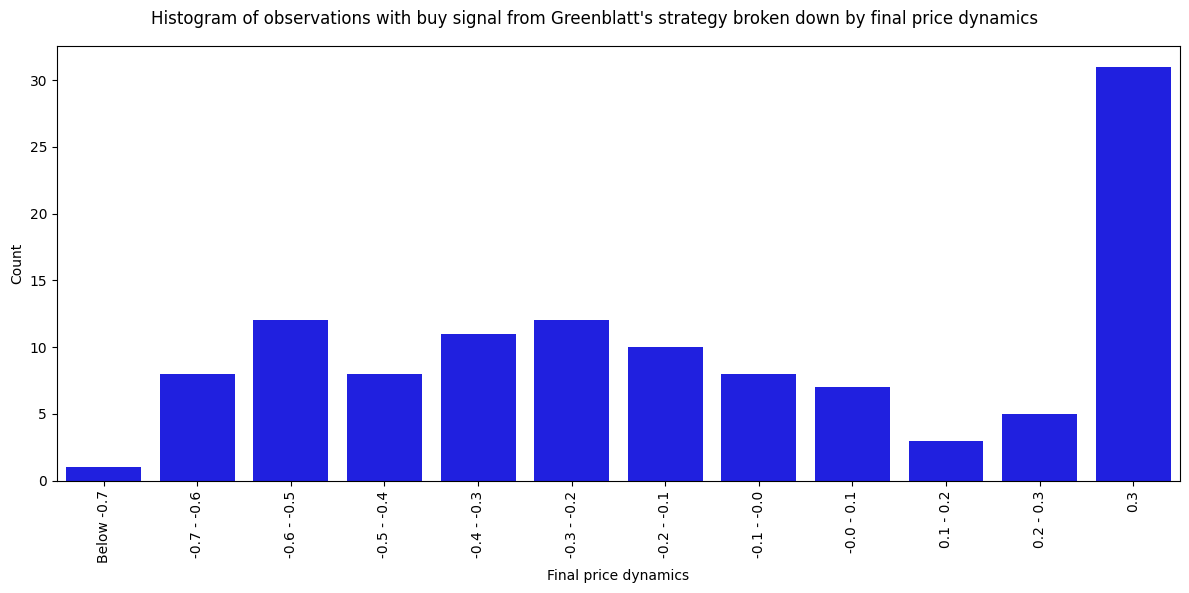

In [197]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(
    x=pd.cut(
        greenblatt_df[greenblatt_df.buy == 'Yes'].final_price_dynamics,
        bins=list(np.arange(-.8, .4, .1)),
        labels=['Below -0.7'] + [f'{round(i, 1)} - {round(i + 0.1, 1)}' for i in np.arange(-.7, .3, .1)] + ['0.3']
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Final price dynamics')
ax.set_ylabel('Count')

plt.suptitle('Histogram of observations with buy signal from Greenblatt\'s strategy broken down by final price dynamics')

plt.tight_layout();

The Greenblatt's strategy was profitable in only 1/3 of analyzed quarters and outperformed zero effort strategy (i.e. investing in WIG) in 1/4 of analyzed periods. The Greenblatt's stategy brought the total loss of -13.82 (i.e. almost -1400%), while the zero effort strategy was actually profitable (3.23).

In [122]:
greenblatt_return_df = pd.DataFrame({
    'Greenblatt\'s strategy':greenblatt_df[
        greenblatt_df.buy == 'Yes'
    ].groupby('quarter').final_price_dynamics.sum(),
    'Zero effort strategy':greenblatt_df.groupby('quarter').final_wig_dynamics.mean()
})

g_stat_3 = greenblatt_return_df.shape[0]

g_stat_4 = greenblatt_return_df[
    greenblatt_return_df['Greenblatt\'s strategy'] > 0
]['Greenblatt\'s strategy'].count()

g_stat_5 = greenblatt_return_df[
    greenblatt_return_df['Zero effort strategy'] > 0
]['Zero effort strategy'].count()

g_stat_6 = greenblatt_return_df[
    greenblatt_return_df['Greenblatt\'s strategy'] > greenblatt_return_df['Zero effort strategy']
]['Greenblatt\'s strategy'].count()

g_stat_7 = greenblatt_return_df['Greenblatt\'s strategy'].sum().round(2)

g_stat_8 = greenblatt_return_df['Zero effort strategy'].sum().round(2)

print(f'Number of analyzed quarters: {g_stat_3}')
print(f'Number of profitable quarters using Greenblatt\'s strategy: {g_stat_4} ({round(100 * g_stat_4 / g_stat_3)}%)')
print(f'Number of profitable quarters using zero effort strategy: {g_stat_5} ({round(100 * g_stat_5 / g_stat_3)}%)')
print(f'Number of quarters in which Greenblatt\'s strategy outperformed zero effort strategy: {g_stat_6} ({round(100 * g_stat_6 / g_stat_3)}%)')
print(f'Total return on Greenblatt\'s strategy: {g_stat_7}')
print(f'Total return on zero effort strategy: {g_stat_8}')



Number of analyzed quarters: 69
Number of profitable quarters using Greenblatt's strategy: 22 (32%)
Number of profitable quarters using zero effort strategy: 43 (62%)
Number of quarters in which Greenblatt's strategy outperformed zero effort strategy: 18 (26%)
Total return on Greenblatt's strategy: -13.82
Total return on zero effort strategy: 3.23


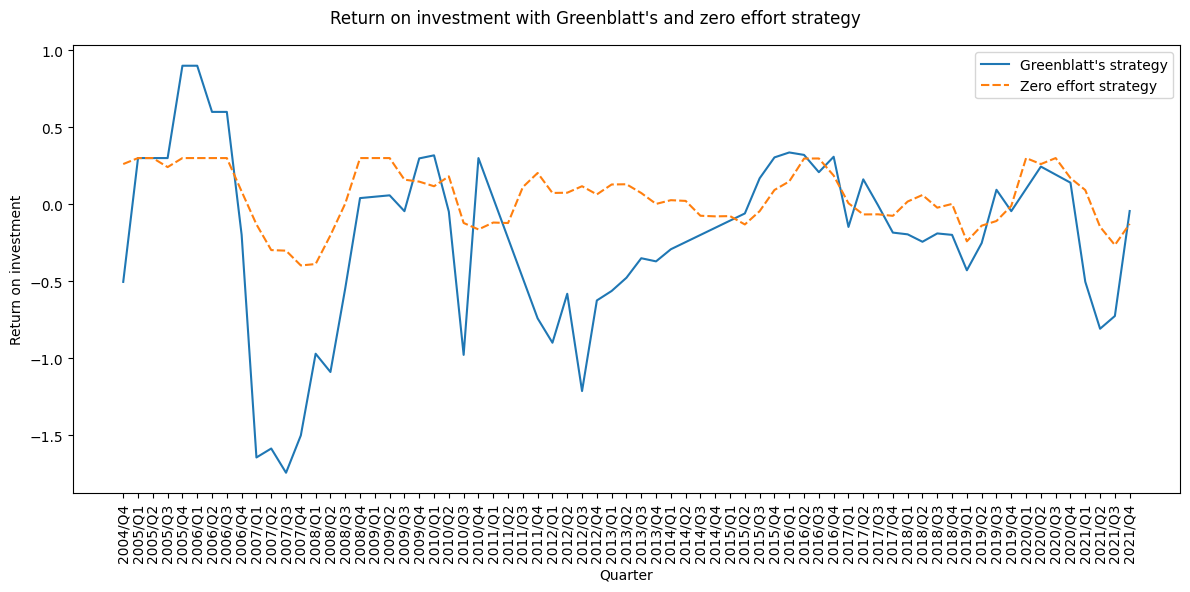

In [205]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=greenblatt_return_df,
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_ylabel('Return on investment')
ax.set_xlabel('Quarter')

plt.suptitle('Return on investment with Greenblatt\'s and zero effort strategy')

plt.tight_layout();

The company's capitalization in USD is the first element of Greenblatt's strategy. The range of this feature is from USD 6.3 thousand to USD 75 billion with mean value of USD 411 million, though the median is USD 40 million. The distribution of this variable is right-skewed. Almost 55% of observations fall below the strategy treshold of USD 50 million.

In [81]:
print('The basic statistics of capitalization in USD in Greenblatt\'s strategy:')
print(greenblatt_df.capitalization_usd.describe())
print('\nCapitalization in USD million in Greenblatt\'s strategy:')
print(pd.Series(np.where(
    greenblatt_df.capitalization_usd > 5e7,
    'Over USD 50 million', 'Below USD 50 million'
)).value_counts())

print(f'\nSkewness of capitalization in USD in Greenblatt\'s strategy: {greenblatt_df.capitalization_usd.skew().round(2)}')

The basic statistics of capitalization in USD in Greenblatt's strategy:
count         17521.00
mean      411130728.42
std      1809740833.12
min            6306.89
25%        13804490.91
50%        39984750.00
75%       150920932.61
max     74944024919.08
Name: capitalization_usd, dtype: float64

Capitalization in USD million in Greenblatt's strategy:
Below USD 50 million    9635
Over USD 50 million     7886
dtype: int64

Skewness of capitalization in USD in Greenblatt's strategy: 12.45


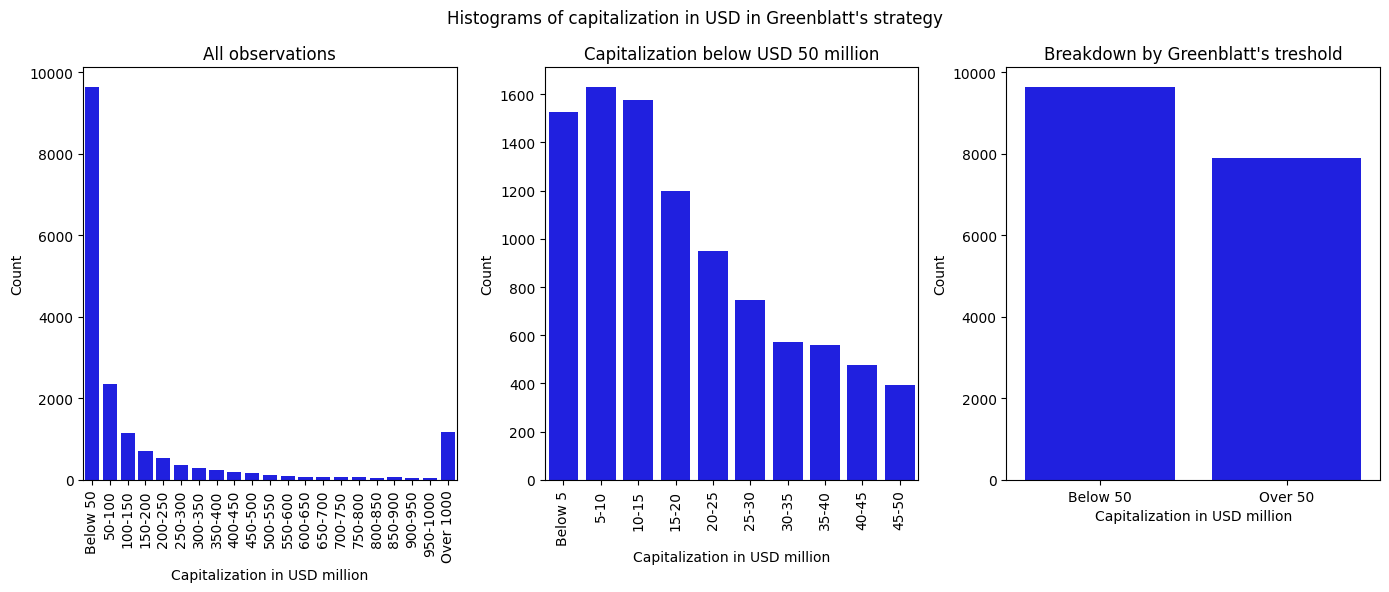

In [198]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.countplot(
    x=pd.cut(
        greenblatt_df.capitalization_usd,
        bins=list(np.arange(0, 10.5e8, 5e7)) + [7.5e10],
        labels=['Below 50'] + [f'{i}-{i+50}' for i in range(50, 1000, 50)] + ['Over 1000']
    ),
    color='blue',
    ax=axs[0]
)

sns.countplot(
    x=pd.cut(
        greenblatt_df[greenblatt_df.capitalization_usd < 5e7].capitalization_usd,
        bins=list(np.arange(0, 5.5e7, 5e6)),
        labels=['Below 5'] + [f'{i}-{i+5}' for i in range(5, 50, 5)]
    ),
    color='blue',
    ax=axs[1]
)

sns.countplot(
    x=pd.cut(
        greenblatt_df.capitalization_usd,
        bins=[0, 5e7, 7.5e10],
        labels=['Below 50', 'Over 50']
    ),
    color='blue',
    ax=axs[2]
)

axs[0].tick_params(axis='x', labelrotation=90)
axs[1].tick_params(axis='x', labelrotation=90)

axs[0].set_xlabel('Capitalization in USD million')
axs[1].set_xlabel('Capitalization in USD million')
axs[2].set_xlabel('Capitalization in USD million')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')

plt.suptitle('Histograms of capitalization in USD in Greenblatt\'s strategy')
axs[0].set_title('All observations')
axs[1].set_title('Capitalization below USD 50 million')
axs[2].set_title('Breakdown by Greenblatt\'s treshold')

plt.tight_layout();

The boxplots below indicate, that Greenblatt's treshold for capitalization in USD is not proper for analyzed dataset. The mean final price dynamics is actually higher for companies with capitalization below USD 50 million then the rest (and even higher for companies with capitalization below USD 15 million). Moreover, there are number of intervals which should minimize losses a bit, i.e. have either minimum value or 75th percentile closer to 0 - however, all intervals contain some observations with negative final price dynamics.

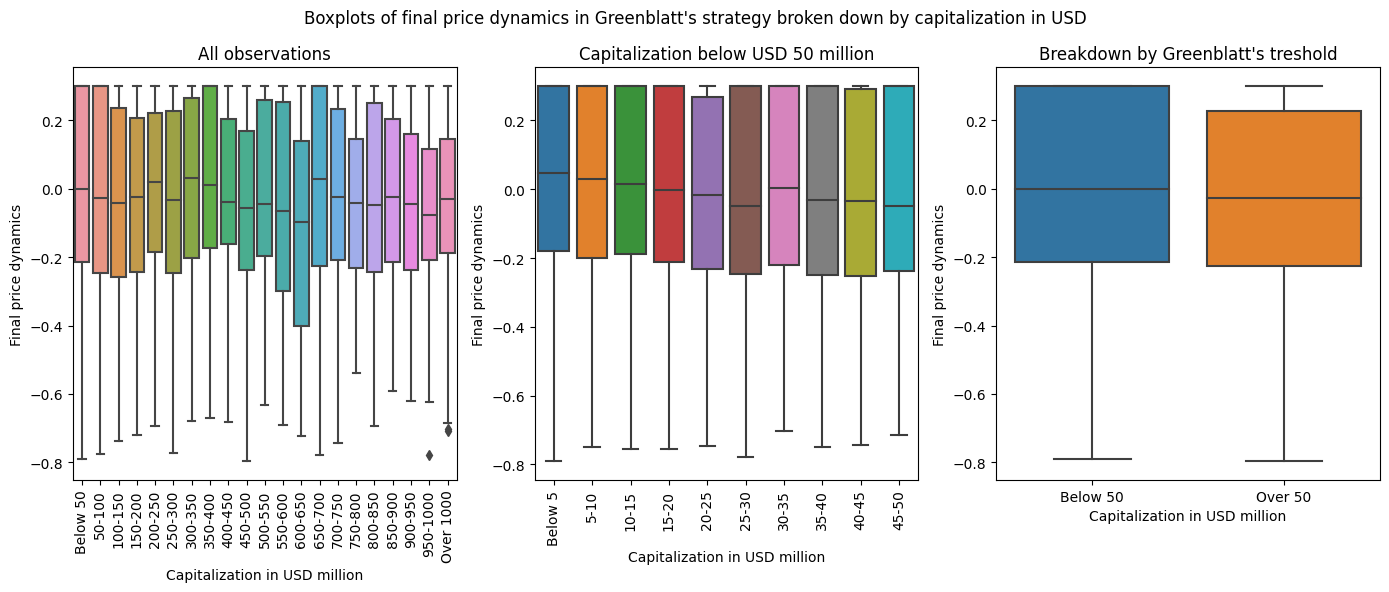

In [152]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.boxplot(
    x=pd.cut(
        greenblatt_df.capitalization_usd,
        bins=list(np.arange(0, 10.5e8, 5e7)) + [7.5e10],
        labels=['Below 50'] + [f'{i}-{i+50}' for i in range(50, 1000, 50)] + ['Over 1000']
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[0]
)

sns.boxplot(
    x=pd.cut(
        greenblatt_df[greenblatt_df.capitalization_usd < 5e7].capitalization_usd,
        bins=list(np.arange(0, 5.5e7, 5e6)),
        labels=['Below 5'] + [f'{i}-{i+5}' for i in range(5, 50, 5)]
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[1]
)

sns.boxplot(
    x=pd.cut(
        greenblatt_df.capitalization_usd,
        bins=[0, 5e7, 7.5e10],
        labels=['Below 50', 'Over 50']
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[2]
)

axs[0].tick_params(axis='x', labelrotation=90)
axs[1].tick_params(axis='x', labelrotation=90)

axs[0].set_xlabel('Capitalization in USD million')
axs[1].set_xlabel('Capitalization in USD million')
axs[2].set_xlabel('Capitalization in USD million')

axs[0].set_ylabel('Final price dynamics')
axs[1].set_ylabel('Final price dynamics')
axs[2].set_ylabel('Final price dynamics')

plt.suptitle('Boxplots of final price dynamics in Greenblatt\'s strategy broken down by capitalization in USD')
axs[0].set_title('All observations')
axs[1].set_title('Capitalization below USD 50 million')
axs[2].set_title('Breakdown by Greenblatt\'s treshold')

plt.tight_layout();

Looking at proportion of interesting investments confirms that companies with capitalization below USD 50 million gave greater chance of return of investment of at least 30%. Especially observations with capitalization below USD 15 million - or even 5 million - are promising.

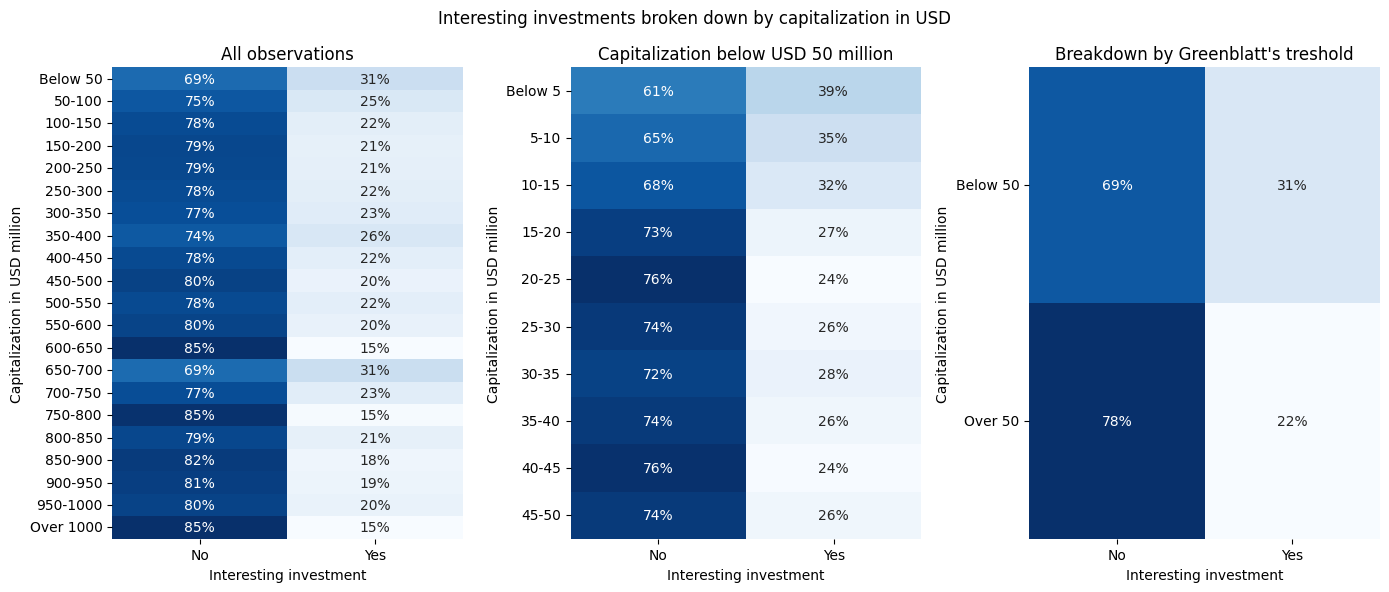

In [204]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df.capitalization_usd,
            bins=list(np.arange(0, 10.5e8, 5e7)) + [7.5e10],
            labels=['Below 50'] + [f'{i}-{i+50}' for i in range(50, 1000, 50)] + ['Over 1000']
        ),
        greenblatt_df.interesting_investment,
        normalize='index'
    ),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df[greenblatt_df.capitalization_usd < 5e7].capitalization_usd,
            bins=list(np.arange(0, 5.5e7, 5e6)),
            labels=['Below 5'] + [f'{i}-{i+5}' for i in range(5, 50, 5)]
        ),
        greenblatt_df.interesting_investment,
        normalize='index'
    ),
    axs[1]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df.capitalization_usd,
            bins=[0, 5e7, 7.5e10],
            labels=['Below 50', 'Over 50']
        ),
        greenblatt_df.interesting_investment,
        normalize='index'
    ),
    axs[2]
)

axs[1].tick_params(axis='y', labelrotation=0)
axs[2].tick_params(axis='y', labelrotation=0)

axs[0].set_xlabel('Interesting investment')
axs[1].set_xlabel('Interesting investment')
axs[2].set_xlabel('Interesting investment')

axs[0].set_ylabel('Capitalization in USD million')
axs[1].set_ylabel('Capitalization in USD million')
axs[2].set_ylabel('Capitalization in USD million')

plt.suptitle('Interesting investments broken down by capitalization in USD')
axs[0].set_title('All observations')
axs[1].set_title('Capitalization below USD 50 million')
axs[2].set_title('Breakdown by Greenblatt\'s treshold')

plt.tight_layout();

The position in Greenblatt's ranking is a very limiting variable - only 663 observations (less than 4% of whole subdataset) passed this constrain. This feature represents an average position in EV/EBIT ranking (the lower value of EV/EBIT the better, excluding negative values) and ROIC ranking (the higher value of ROIC the better), so we have to look also at these features to understand influence of Greenblatt's ranking.

As we can see in the boxplots below, the mean value and 75th percentile of final price dynamics grow slowly with lower position in Greenblatt's ranking. Simultaneously, in EV/EBIT and ROIC rankings the average value and the 3rd quartile decrease with lower position. This situation occurs because of construction of Greenblatt's ranking - it takes not only observations with top position in each ranking, but also those, which have good EV/EBIT value and worse ROIC value (or vice versa). In the result, the mediocre observations are taken into consideration.

In this case, better performance of Greenblatt's strategy may be achieved by using completely different constrain, which would take into account only observations in, e.g. top 10 in both (EV/EBIT and ROIC) rankings.

In [180]:
print('Greenblatt\'s ranking:')
print(pd.Series(np.where(
    greenblatt_df.greenblatt_rank <= 10,
    'Below 11th position', 'Over 10th position'
)).value_counts())

Greenblatt's ranking:
Over 10th position     16858
Below 11th position      663
dtype: int64


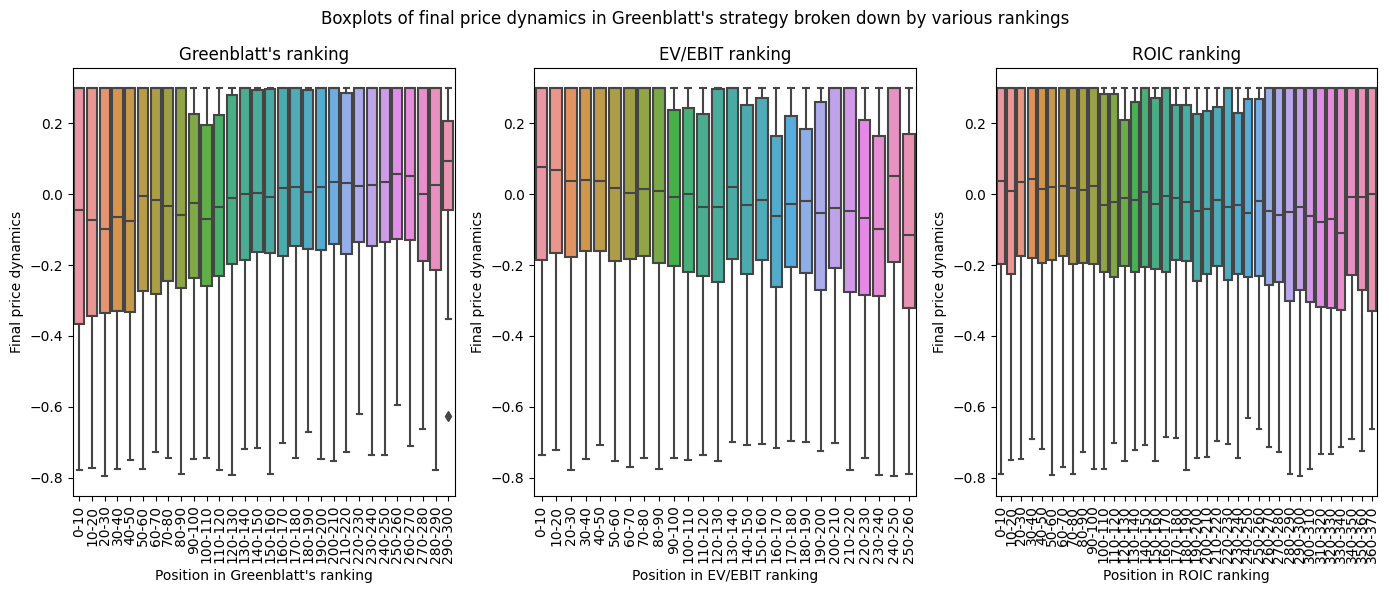

In [192]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.boxplot(
    x=pd.cut(
        greenblatt_df.greenblatt_rank,
        bins=range(0, 310, 10),
        labels=[f'{i}-{i+10}' for i in range(0, 300, 10)]
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[0]
)

sns.boxplot(
    x=pd.cut(
        greenblatt_df.rank_ev_ebit,
        bins=range(0, 270, 10),
        labels=[f'{i}-{i+10}' for i in range(0, 260, 10)]
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[1]
)

sns.boxplot(
    x=pd.cut(
        greenblatt_df.rank_roic,
        bins=range(0, 380, 10),
        labels=[f'{i}-{i+10}' for i in range(0, 370, 10)]
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[2]
)

axs[0].tick_params(axis='x', labelrotation=90)
axs[1].tick_params(axis='x', labelrotation=90)
axs[2].tick_params(axis='x', labelrotation=90)

axs[0].set_xlabel('Position in Greenblatt\'s ranking')
axs[1].set_xlabel('Position in EV/EBIT ranking')
axs[2].set_xlabel('Position in ROIC ranking')

axs[0].set_ylabel('Final price dynamics')
axs[1].set_ylabel('Final price dynamics')
axs[2].set_ylabel('Final price dynamics')

plt.suptitle('Boxplots of final price dynamics in Greenblatt\'s strategy broken down by various rankings')
axs[0].set_title('Greenblatt\'s ranking')
axs[1].set_title('EV/EBIT ranking')
axs[2].set_title('ROIC ranking')

plt.tight_layout();

The plots below confirm that capitalization greater than USD 50 million and Greenblatt's ranking position better than 10th do not influence high_growth. Proportion of high_growth observations is even higher for companies with capitalization lower than USD 50 million than other observations. The position in the Greenblatt's ranking is also irrelevant - proportion of high_growth observation remains more or less the same for positions from 1st to 250th. Similarly, the industries excluded by this strategy did not perform significantly better or worse than the rest of them.

In [94]:
def custom_heatmap(cross_tab, ax):
    """Function for simpler creating heatmaps"""
    return sns.heatmap(
        data=cross_tab,
        cmap='Blues',
        fmt='.0%',
        annot=True,
        cbar=False,
        ax=ax
    )

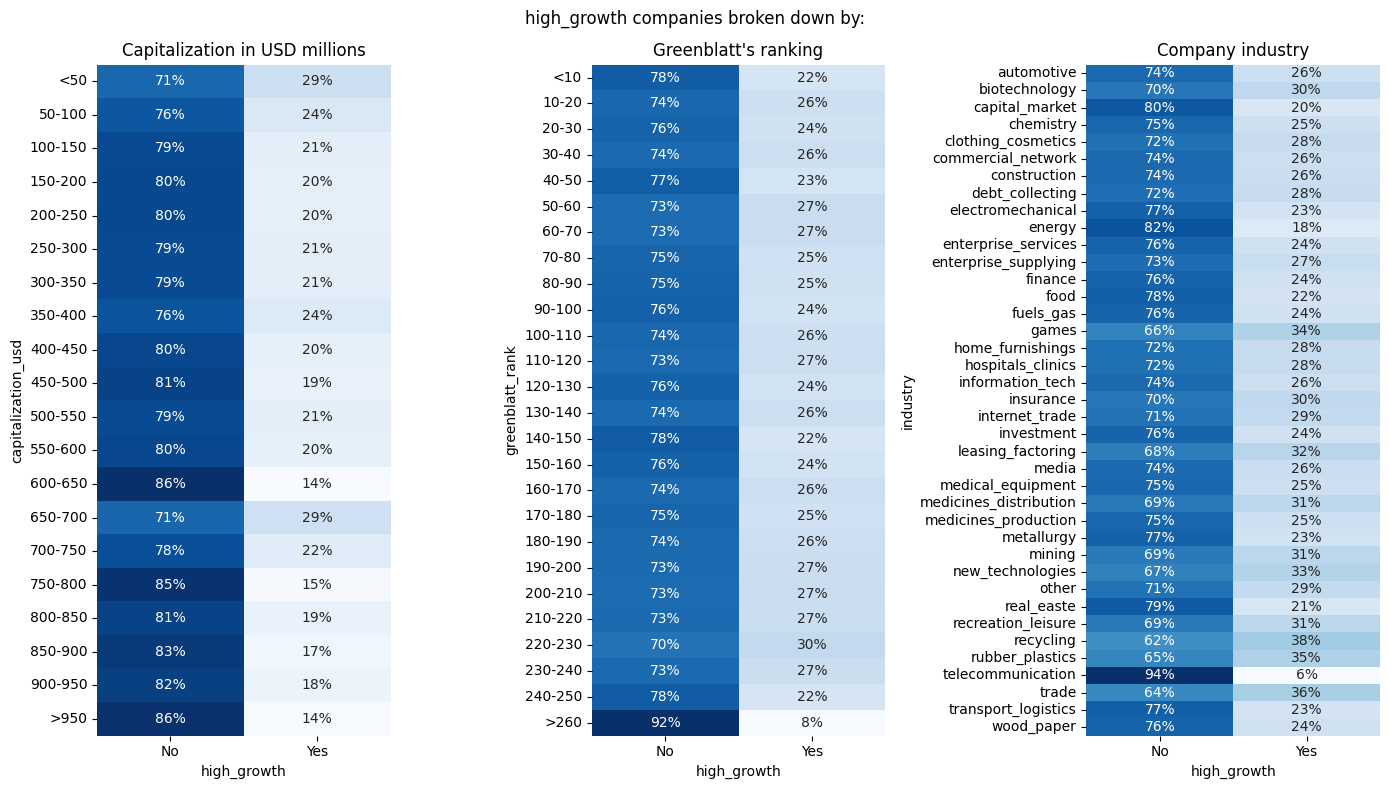

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(14, 8))

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df.capitalization_usd,
            bins=list(np.linspace(0, 10e8, 21)),
            labels=['<50'] + [f'{i}-{i+50}' for i in range(50, 950, 50)] + ['>950']
        ).fillna('>950'),
        greenblatt_df.high_growth,
        normalize='index'
    ),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df.greenblatt_rank,
            bins=list(range(0, 270, 10)),
            labels=['<10'] + [f'{i}-{i+10}' for i in range(10, 250, 10)] + ['>260']
        ).fillna('>260'),
        greenblatt_df.high_growth,
        normalize='index'
    ),
    axs[1]
)

custom_heatmap(
    pd.crosstab(
        greenblatt_df.industry,
        greenblatt_df.high_growth,
        normalize='index'
    ),
    axs[2]
)

plt.suptitle('high_growth companies broken down by:')
axs[0].set_title('Capitalization in USD millions')
axs[1].set_title('Greenblatt\'s ranking')
axs[2].set_title('Company industry')

plt.tight_layout();

It is worth noting that this strategy qualified as many as 117 observations that resulted in a loss in one year (with -63% as minimum). It means that only 56% of buy signals would result in any profit. Assuming that an equal amount of money was invested on each buy signal and that a company shares were sold at the best moment, the cumulated profit of Greenblatt's strategy is slightly more than 2% of cumulated profit of high_growth companies - of course assuming, that the loss-making companies will be sold when the decrease is minimized.

In [45]:
gdf_0_adj_price_change_y = greenblatt_df[
    (greenblatt_df.adj_price_change_y < 0) & (greenblatt_df.buy == 'Yes')
].adj_price_change_y.count()

gdf_lowest_adj_price_change_y = greenblatt_df[
    greenblatt_df.buy == 'Yes'
].adj_price_change_y.min().round(2)

gdf_cum_profit_greenblatt = (
    100*greenblatt_df[greenblatt_df.buy == 'Yes'].adj_price_change_y.sum()
).round(2)

gdf_cum_profit_hg = (30*dataset.high_growth.value_counts()[1]).round(2)



print(f'Number of adj_price_change_y below 0 with buy signal: {gdf_0_adj_price_change_y}')
print(f'The lowest value of adj_price_change_y with buy signal: {gdf_lowest_adj_price_change_y}')
print(f'The cumulated profit of Greenblatt\'s strategy: {gdf_cum_profit_greenblatt}%')
print(f'The cumulated profit of high_growth: {gdf_cum_profit_hg}%')

Number of adj_price_change_y below 0 with buy signal: 117
The lowest value of adj_price_change_y with buy signal: -0.63
The cumulated profit of Greenblatt's strategy: 3395.53%
The cumulated profit of high_growth: 150150%


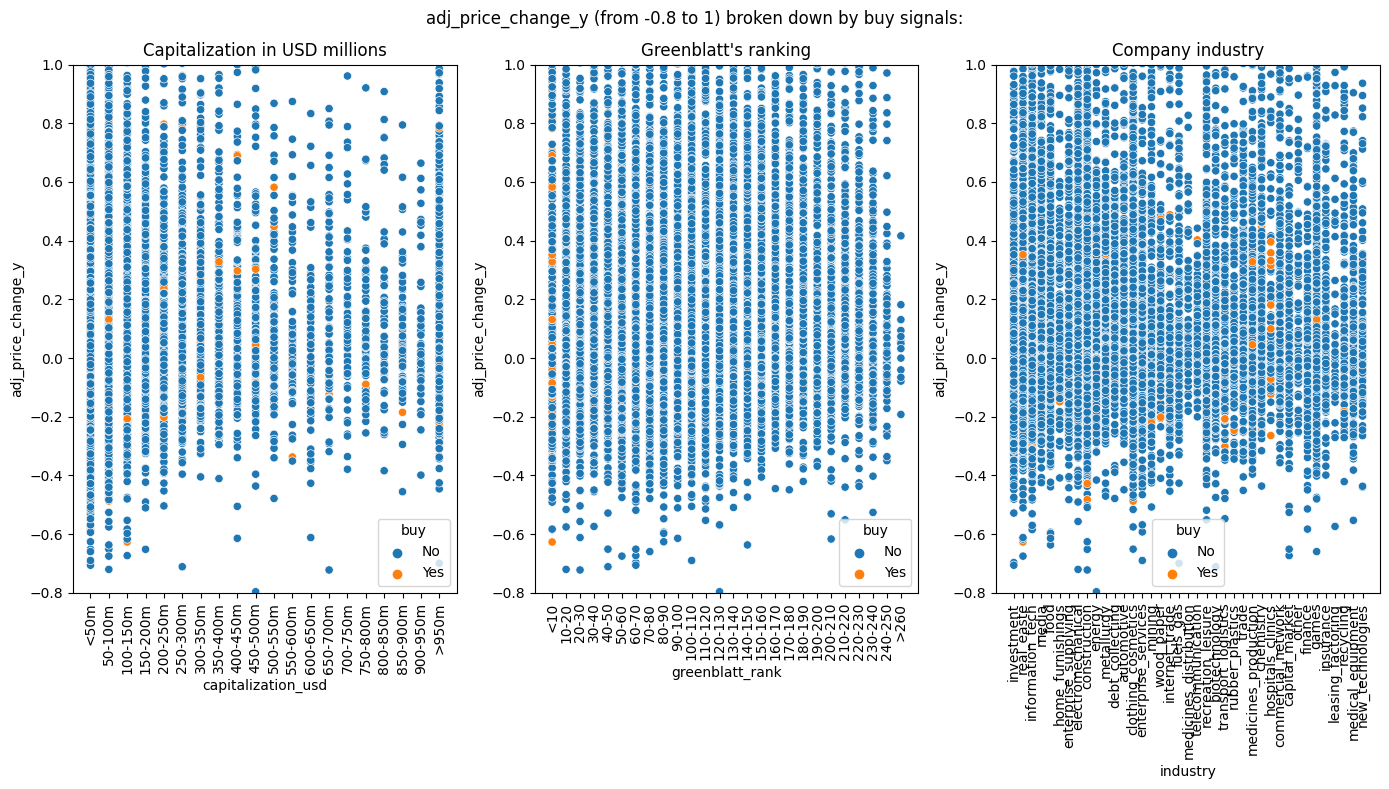

In [107]:
adj_min = greenblatt_df.adj_price_change_y.min().round(1)

fig, axs = plt.subplots(1, 3, figsize=(14, 8))

sns.scatterplot(
    x=pd.cut(
        greenblatt_df.capitalization_usd,
        bins=list(np.linspace(0, 10e8, 21)),
        labels=['<50m'] + [f'{i}-{i+50}m' for i in range(50, 950, 50)] + ['>950m']
    ).fillna('>950m'),
    y=greenblatt_df.adj_price_change_y,
    hue=greenblatt_df.buy,
    ax=axs[0]
)

sns.scatterplot(
    x=pd.cut(
        greenblatt_df.greenblatt_rank,
        bins=list(range(0, 270, 10)),
        labels=['<10'] + [f'{i}-{i+10}' for i in range(10, 250, 10)] + ['>260']
    ).fillna('>260'),
    y=greenblatt_df.adj_price_change_y,
    hue=greenblatt_df.buy,
    ax=axs[1]
)

sns.scatterplot(
    x=greenblatt_df.industry,
    y=greenblatt_df.adj_price_change_y,
    hue=greenblatt_df.buy,
    ax=axs[2]
)

plt.setp(axs, ylim=(adj_min, 1))
axs[0].tick_params(axis='x', labelrotation=90)
axs[1].tick_params(axis='x', labelrotation=90)
axs[2].tick_params(axis='x', labelrotation=90)

fig.suptitle(f'adj_price_change_y (from {adj_min} to 1) broken down by buy signals:')
axs[0].set_title('Capitalization in USD millions')
axs[1].set_title('Greenblatt\'s ranking')
axs[2].set_title('Company industry')

plt.tight_layout();


# Martin Zweig's strategy

This strategy assumes, that we invest only in companies which:
- have net earnings y/y greater than 115%
- have sales revenues y/y greater than 115%
- have net earnings in the last quarter greater than net earnings in the corresponding quarter of the previous year (e.g. for observation in Q3 2020 the net earnings in Q2 2020 have to be greater than net earnings in Q2 2019)
- have net earnings in two quarters ago greater than net earnings in the corresponding quarter of the previous year (e.g. for observation in Q3 2020 the net earnings in Q1 2020 have to be greater than net earnings in Q1 2019)
- have sales revenues in the last quarter greater than sales revenues in the corresponding quarter of the previous year
- have sales revenues in two quarters ago greater than sales revenues in the corresponding quarter of the previous year
- have relative strength from the last 6 months greater than 0
- have price/earnings ratio lower than doubled average price/earnings ratio for whole market in given quarter

For this strategy the following variables would be used:
- high_growth: target variable described above;
- net_earnings: various variables with net earnings values in different quarters;
- sales_revenues: various variables with sales revenues values in different quarters;
- relative_strength_6m: change of company's price in the last 6 months divided by change of Warsaw Stock Exchange Index value in the last 6 months;
- price_earnings: company's price divided by net earnings divided by number of shares;
- avg_price_earnings: average price/earnings ratio for whole market in given quarter;
- buy: signal from Zweig's strategy, Yes if company should be bought, No otherwise.

In [113]:
# Filter data
zweig_df = dataset.filter([
    'quarter', 'company_code', 'adj_price_change_y', 'high_growth',
    'net_earnings_yy', 'net_earnings_1Q', 'net_earnings_2Q', 'net_earnings_5Q', 'net_earnings_6Q',
    'sales_revenues_yy', 'sales_revenues_1Q', 'sales_revenues_2Q', 'sales_revenues_5Q', 'sales_revenues_6Q',
    'relative_strength_6m', 'price_earnings', 'avg_price_earnings'
])

# Add column 'buy' for observations, which meet strategy conditions
# zweig_df['buy'] = np.where(
#     (zweig_df.net_earnings_yy > 1.15) &
#     (zweig_df.sales_revenues_yy > 1.15) &
#     (zweig_df.net_earnings_1Q > zweig_df.net_earnings_5Q) &
#     (zweig_df.net_earnings_2Q > zweig_df.net_earnings_6Q) &
#     (zweig_df.sales_revenues_1Q > zweig_df.sales_revenues_5Q) &
#     (zweig_df.sales_revenues_2Q > zweig_df.sales_revenues_6Q) &
#     (zweig_df.relative_strength_6m > 0) &
#     (zweig_df.price_earnings > 2 * zweig_df.avg_price_earnings),
#     'Yes', 'No'
# )
# zweig_df = zweig_df.dropna()

The analyzed subset contains 18 665 observations (91% of original dataset). The distribution of adj_price_change_y is close to original set. The subset omitted 280 high_growth observations (5 005 in original set vs 4 725 in subset).

In [114]:
print('Basic statistics of zweig_df:')
zweig_df.describe().round(2)

Basic statistics of zweig_df:


,adj_price_change_y,net_earnings_yy,net_earnings_1Q,net_earnings_2Q,net_earnings_5Q,net_earnings_6Q,sales_revenues_yy,sales_revenues_1Q,sales_revenues_2Q,sales_revenues_5Q,sales_revenues_6Q,relative_strength_6m,price_earnings,avg_price_earnings
count,20449.00,19557.00,0.0,0.0,0.0,0.0,18664.00,0.0,0.0,0.0,0.0,19043.00,14838.00,20449.00
mean,0.25,-0.48,NaN,NaN,NaN,NaN,1.79,NaN,NaN,NaN,NaN,0.20,59.08,57.41
std,1.11,162.57,NaN,NaN,NaN,NaN,63.27,NaN,NaN,NaN,NaN,22.80,1359.90,96.04
min,-0.80,-16083.00,NaN,NaN,NaN,NaN,-1170.75,NaN,NaN,NaN,NaN,-869.57,0.01,13.71
25%,-0.04,-0.63,NaN,NaN,NaN,NaN,-0.09,NaN,NaN,NaN,NaN,-1.44,7.80,25.39
50%,0.07,0.08,NaN,NaN,NaN,NaN,0.07,NaN,NaN,NaN,NaN,0.49,12.48,32.81
75%,0.29,0.98,NaN,NaN,NaN,NaN,0.29,NaN,NaN,NaN,NaN,2.31,20.72,50.65
max,66.32,3234.00,NaN,NaN,NaN,NaN,7744.29,NaN,NaN,NaN,NaN,2441.38,130019.98,925.52
